In [321]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sci
import cantera as ct
import time

In [322]:
# Constants
M_N = 14; # Molar mass (g/mol)
M_O = 16;
M_C = 12;
M_H = 1;
M_Ar = 40;

In [323]:
# Experimental conditions - Defined by the user
p = ct.one_atm; # Pressure (atm)
temp = 300; # Temperature (K)
phi = 1.83; # Equivalence ratio (-)
chi_h2 = 0; # Hydrogen volumetric fraction (-)
chi_ch4 = 1-chi_h2; # Methane volumetric fraction (-)

In [324]:
# Balancing chemical equation
w = (4-3*chi_h2)/2; # Air weight (balanced by hand)
beta = .79/.21; # Nitrogen fraction in air (-)
n_dil_Ar = 0; # Argon moles used to dilute the mixture for Ea measurements (i.e., 0 to 0.2 moles)
n_dil_N2 = n_dil_Ar*M_Ar/(2*M_N); # Equivalent mass of di-nitrogen

In [325]:
# Initiating time counter
start = time.time()

In [326]:
# Setting up Cantera simulation
# Reactants and molar fractions (-)
reactants = {'CH4':chi_ch4, 'H2':chi_h2, 'O2':w/phi, 'N2':beta*w/phi-n_dil_N2, 'Ar':n_dil_Ar};
width = .01; # Domain width (m)
loglevel = 0; # Flag to display verbose output during solving (0 to 5, 0 being no verbose)
gas = ct.Solution('gri30.yaml'); # Reaction mechanism
gas.TPX = temp, p, reactants; # Supplying experimental conditions 

In [327]:
# Locating relevant species
#relevant_species = ["CH4","H2","O2","N2","CO2","H2O"];
relevant_species = ["N2","O2","CO2","AR","H2O","CH4","CO","H2","OH","C2H4","HCN","H","NO","O","CH3","C3H8","CH2O"];
relevant_species_index = [gas.species_index(i) for i in gas.species_names and relevant_species];
relevant_species_index

[47, 3, 15, 48, 5, 13, 14, 0, 4, 24, 40, 1, 35, 2, 12, 50, 17]

In [328]:
# Relevant species scattering cross-sections (normalized by sigma_N2)
sigma_species = np.asarray([1,.859,2.427,.865,.695,2.134,1.245,.216,1.486,5.803,1.689,.148,.983,.171,1.577,12.2,1.99]);

In [329]:
# Setting up flame object
f = ct.FreeFlame(gas,width = width)
f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)

In [330]:
# Solve with mixture-averaged transport model
f.transport_model = 'Mix';
f.solve(loglevel=loglevel, auto=True);

In [331]:
# Setting up dictionary of quantities to be saved
dicto = {'species':relevant_species,'sigma_species':sigma_species,'Lx':f.grid,'Yi':f.Y[relevant_species_index,:],'Xi':f.X[relevant_species_index,:],'T':f.T,'HRR':f.heat_release_rate, 'Di':f.mix_diff_coeffs_mass[relevant_species_index,:], 'rho':f.density, 'nu':f.viscosity, 'lambda':f.thermal_conductivity, 'cp':f.cp, 's':f.velocity, 'phi':phi, 'chi_h2':chi_h2};

In [332]:
# Saving into .mat file -- Not needed
save_name = "simulation/"+str(int(chi_h2*100))+"h2_"+str(round(phi,2))+"phi"+"_sim.mat";
sci.savemat(save_name,mdict=dicto);

In [333]:
print("Time elapsed : " + str(round((time.time()-start),2)) + " seconds.")

Time elapsed : 9.44 seconds.


In [334]:
print("Adiabatic flame temperature : "+ str(round(max(f.T),0)) +" (K)")
print("Unstretched laminar flame speed : "+ str("{:.2e}".format(f.velocity[0])) +" (m/s)")
print("Unstretched laminar flame thickness: "+ str("{:.2e}".format((f.T[-1]-f.T[0])/max(np.gradient(f.T,f.grid)))) +" (m)")

Adiabatic flame temperature : 1746.0 (K)
Unstretched laminar flame speed : 5.25e-02 (m/s)
Unstretched laminar flame thickness: 2.48e-03 (m)


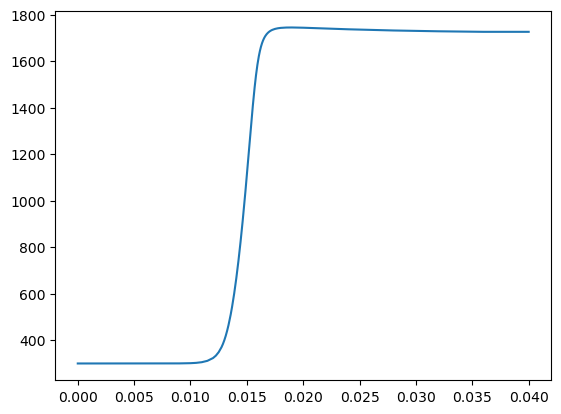

In [335]:
plt.plot(f.grid,f.T)

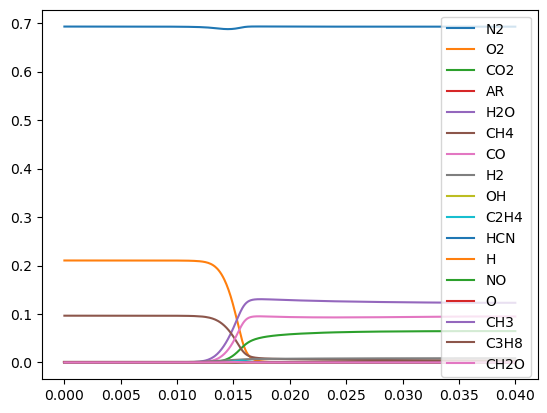

In [336]:
[plt.plot(f.grid,f.Y[i],label = gas.species_name(i)) for i in relevant_species_index]
plt.legend()

In [337]:
np.multiply(f.Y[relevant_species_index,:],sigma_species)

ValueError: operands could not be broadcast together with shapes (17,130) (17,) 

In [ ]:
sigma_species

In [ ]:
np.transpose(sigma_species)

In [ ]:
np.squeeze(f.Y[relevant_species_index,:]).reshape(17, 180)

In [ ]:
np.asarray(sigma_species)*f.Y[relevant_species_index,:]

In [ ]:
type(f.Y[relevant_species_index,:])

In [ ]:
type(sigma_species)

In [ ]:
type(np.asarray(sigma_species))

In [ ]:
(np.asarray(sigma_species)[:,None] @ f.Y[relevant_species_index,:]).shape

In [ ]:
sigma_species.shape